# VISTO CHE POSSO USARE UN UNICO MODELLO PER RISOLVERE SEASONALITY AND TREND USO AUTO SARIMA

con auto sarima it is a method which search for the best parameters. 

library

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox


open file

In [15]:
# Load the dataset
file_path = 'Input_data_timeseries (version 1).xlsx'  # Replace with your file's path
data = pd.read_excel(file_path, sheet_name='db')
display(data)

,ROUTE,ORDER DATE,NUMBER OF ACTUAL ORDERS
0,BELGIUM__BELGIUM,2022-12-13,4
1,BELGIUM__BELGIUM,2022-12-13,1
2,BELGIUM__BELGIUM,2022-12-13,7
3,BELGIUM__BELGIUM,2022-12-13,19
4,BELGIUM__BELGIUM,2022-12-13,22
...,...,...,...
170027,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170028,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170029,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170030,NaN,NaT,772574


pv table for one route

In [16]:
route = data[data['ROUTE'] == 'BELGIUM__BELGIUM']
# Convert ORDER DATE to datetime format
route['ORDER DATE'] = pd.to_datetime(route['ORDER DATE'])
route = route.sort_values('ORDER DATE').set_index('ORDER DATE')
route_data = pd.pivot_table(route, index=route.index, values='NUMBER OF ACTUAL ORDERS', aggfunc='sum')
display(route_data)

C:\Users\elped\AppData\Local\Temp\ipykernel_3284\3115930140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route['ORDER DATE'] = pd.to_datetime(route['ORDER DATE'])


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,1
2022-01-02,0
2022-01-03,50
2022-01-04,41
2022-01-05,49
...,...
2022-12-09,51
2022-12-10,5
2022-12-11,0


slipt data

In [17]:
# Define proportions
#train_size = int(len(route_data) * 0.6)
#val_size = int(len(route_data) * 0.2)
train_size = int(len(route_data) * 0.8)

# Split the data
train = route_data.iloc[:train_size] #60%
#val = route_data.iloc[train_size:train_size + val_size] #20%
#test = route_data.iloc[train_size + val_size:] #20%
test = route_data.iloc[train_size:]

#print(f"Training size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}")
print(f"Training size: {len(train)}, Test size: {len(test)}")

Training size: 277, Test size: 70


In [18]:
display(train)
display(test)

,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,1
2022-01-02,0
2022-01-03,50
2022-01-04,41
2022-01-05,49
...,...
2022-09-30,60
2022-10-01,6
2022-10-02,0


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-10-05,52
2022-10-06,55
2022-10-07,47
2022-10-08,5
2022-10-09,0
...,...
2022-12-09,51
2022-12-10,5
2022-12-11,0


understand the best m: so the seasonal period
the auto_arima function needs the correct m to identify seasonality patterns in your time series. Without it, the model might behave as if the data has no seasonality, which can result in flat predictions.

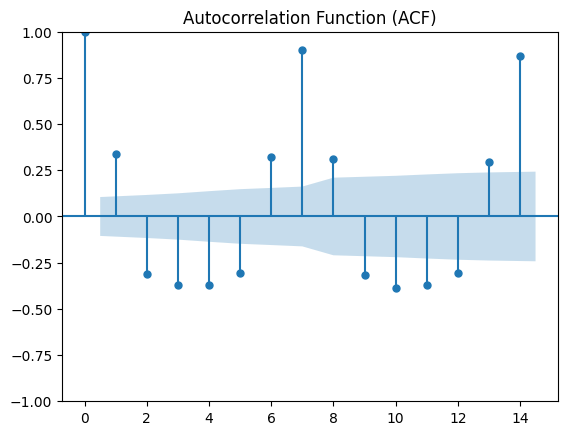

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF
plot_acf(route_data['NUMBER OF ACTUAL ORDERS'], lags=14)
plt.title('Autocorrelation Function (ACF)')
plt.show()
#ok i dont know what is mean


ok da quello che riesco a capire dal grafico sono presenti dei picchi (quelli fuori dalla zona grigia) ogni 7 lag (presenza di ripetizioni, frequenza) quindi indica la presenza di seasonality (quindi provare con m = 7)
mi sembra anche che sia presente una lieve decrescita (presenza di trend??)

In [20]:
#attenzione con d = none significa che cerca il migliore valore di d e potrebbe
#metterci molto
#dovrei metter il parametro m??
#n_job the number of models to fit in prallel in the case of  a grif search
#m indicate the seasonal period i have to specify it??? if i dont't put m the prediction is a line, why??, i try with 30 and i have a good? prediction
#ok to find the best m i have to use the ACF
#messo stepwiese, da qullo che ho capito dovrebbe velocizzare il tutto??
arima_model = auto_arima(train, 
                         start_p =0, start_q=0, d=None, max_p = 5, max_d=2, max_q = 5, 
                         start_P = 1, D = None, start_Q = 1, max_P=2, max_D = 1, max_Q=2,
                         seasonal = True, m = 7,
                         information_criterion = 'aic', n_jobs = 1,
                         suppress_warning = True,
                         error_action = 'ignore',
                         trace = True,
                         stepwiese=True) #ATTENZIONE CAPIRE MEGLIO m

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2103.075, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2648.316, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2180.996, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2646.333, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2465.567, Time=0.08 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2225.907, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=2375.742, Time=0.25 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2061.726, Time=0.42 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2462.960, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.80 s

In [21]:
(p, d, q) = arima_model.order
(P, D, Q, S) = arima_model.seasonal_order

print(f"Best ARIMA order: {p, d, q}")
print(f"Best Seasonal order: {P, D, Q, S}")

Best ARIMA order: (5, 1, 1)
Best Seasonal order: (1, 0, 1, 7)


In [22]:
#Create the model
model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S))  #CAPIRE enformce:invertibili
#Fit
result_SARIMA_auto = model.fit()

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:           NUMBER OF ACTUAL ORDERS   No. Observations:                  277
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -978.669
Date:                           Fri, 29 Nov 2024   AIC                           1975.338
Time:                                   13:27:46   BIC                           2007.922
Sample:                               01-01-2022   HQIC                          1988.413
                                    - 10-04-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2465      0.059      4.209      0.000       0.132       0.361
ar.L2         -0.0206      0.077     -0.268

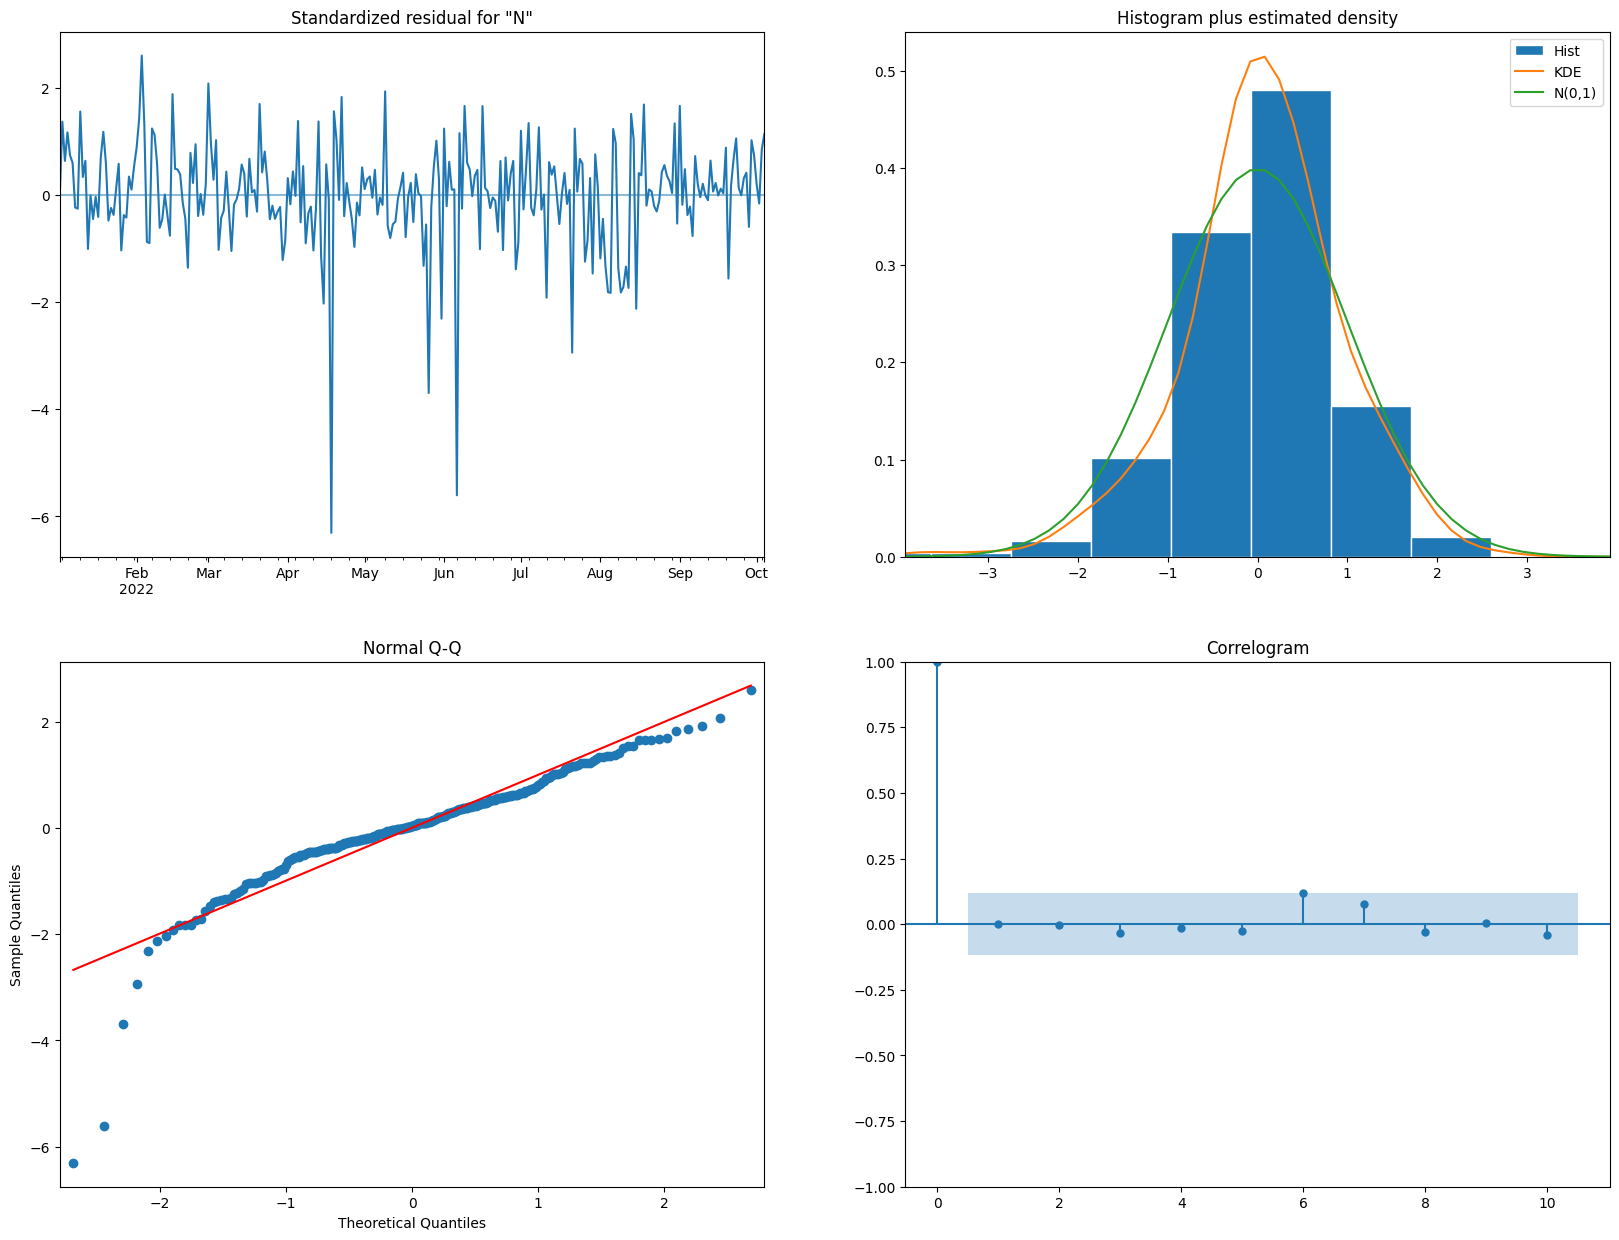

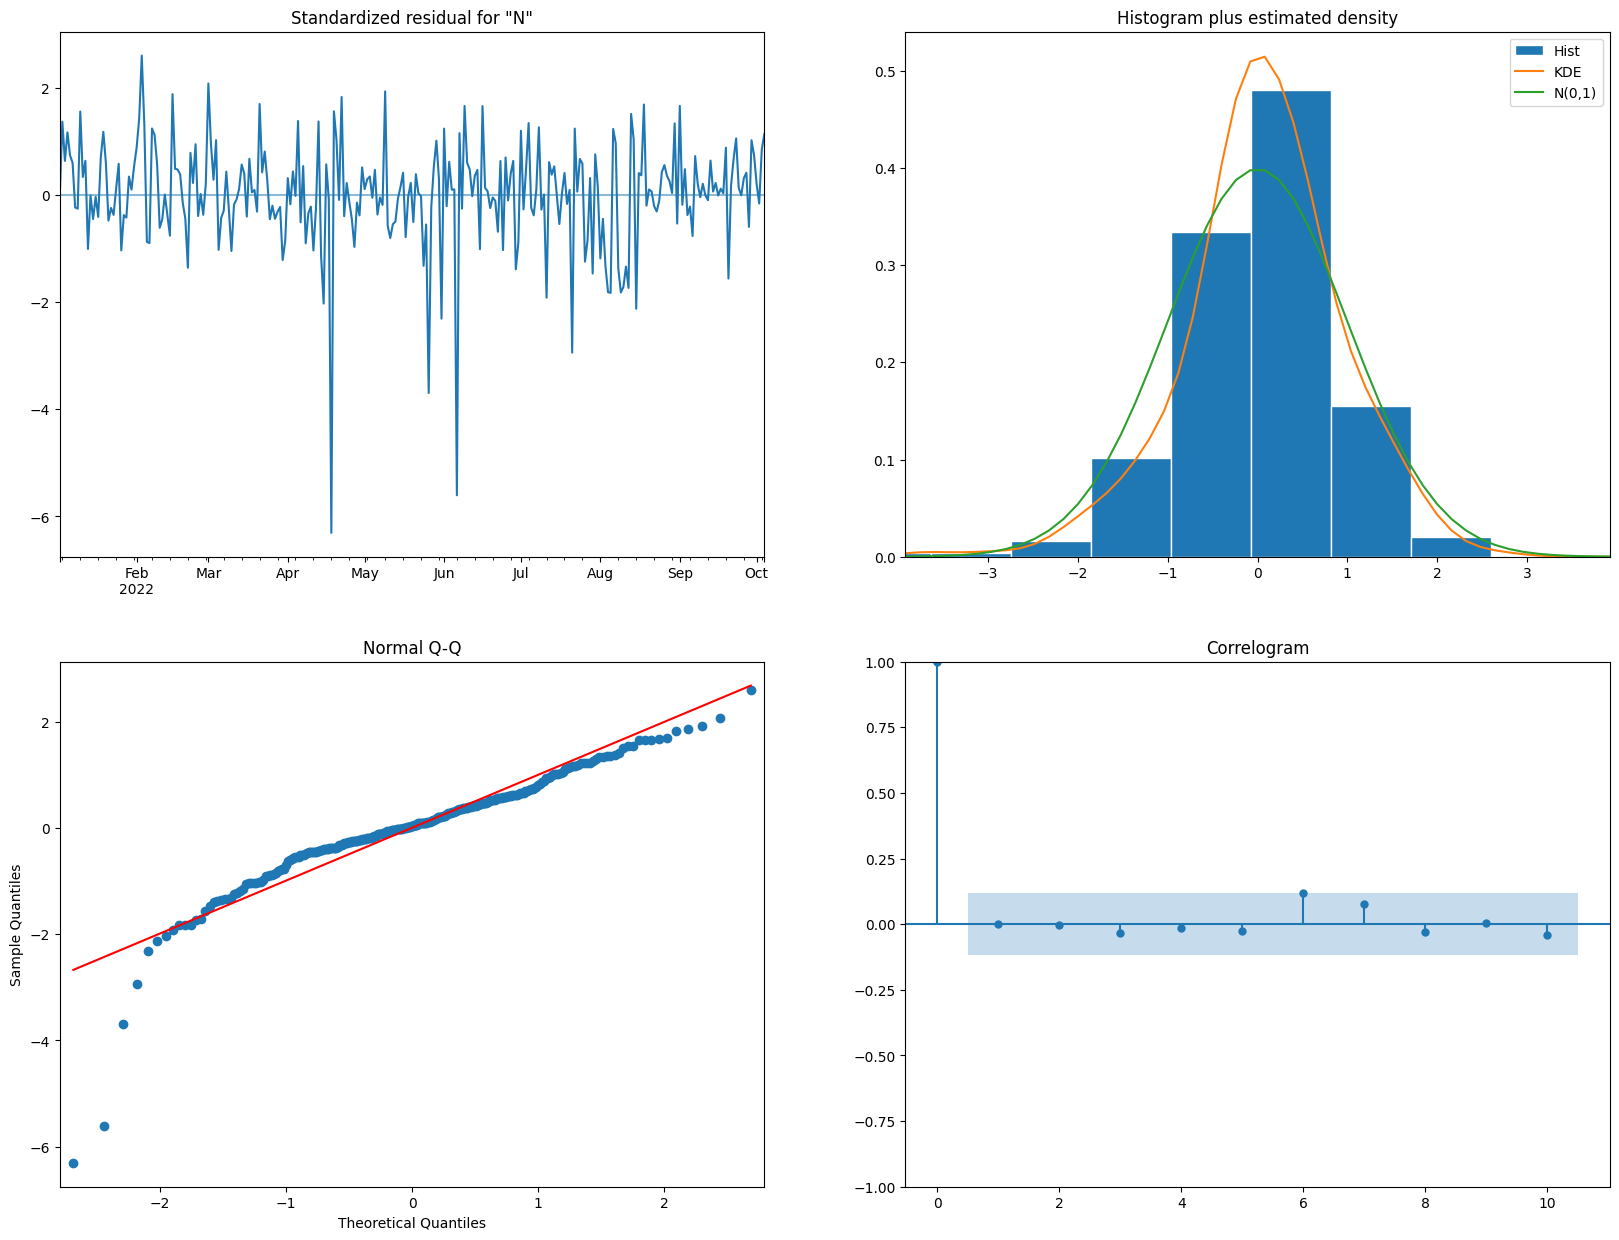

In [23]:
print(result_SARIMA_auto.summary())
result_SARIMA_auto.plot_diagnostics(figsize=(20, 15))

attenione sono presenti dei picchi nella metà di aprile e giungo (festività??)

In [24]:
print('Durbin watson: ',durbin_watson(result_SARIMA_auto.resid))

Durbin watson:  1.7613971824260746


In [25]:
ljung_test = acorr_ljungbox(result_SARIMA_auto.resid, period=52)
ljung_test.head()

,lb_stat,lb_pvalue
1,3.702949,0.054316
2,6.984867,0.030427
3,7.244384,0.064503
4,7.572957,0.108535
5,7.573130,0.181384


In [26]:
display(test.index[0])


Timestamp('2022-10-05 00:00:00')

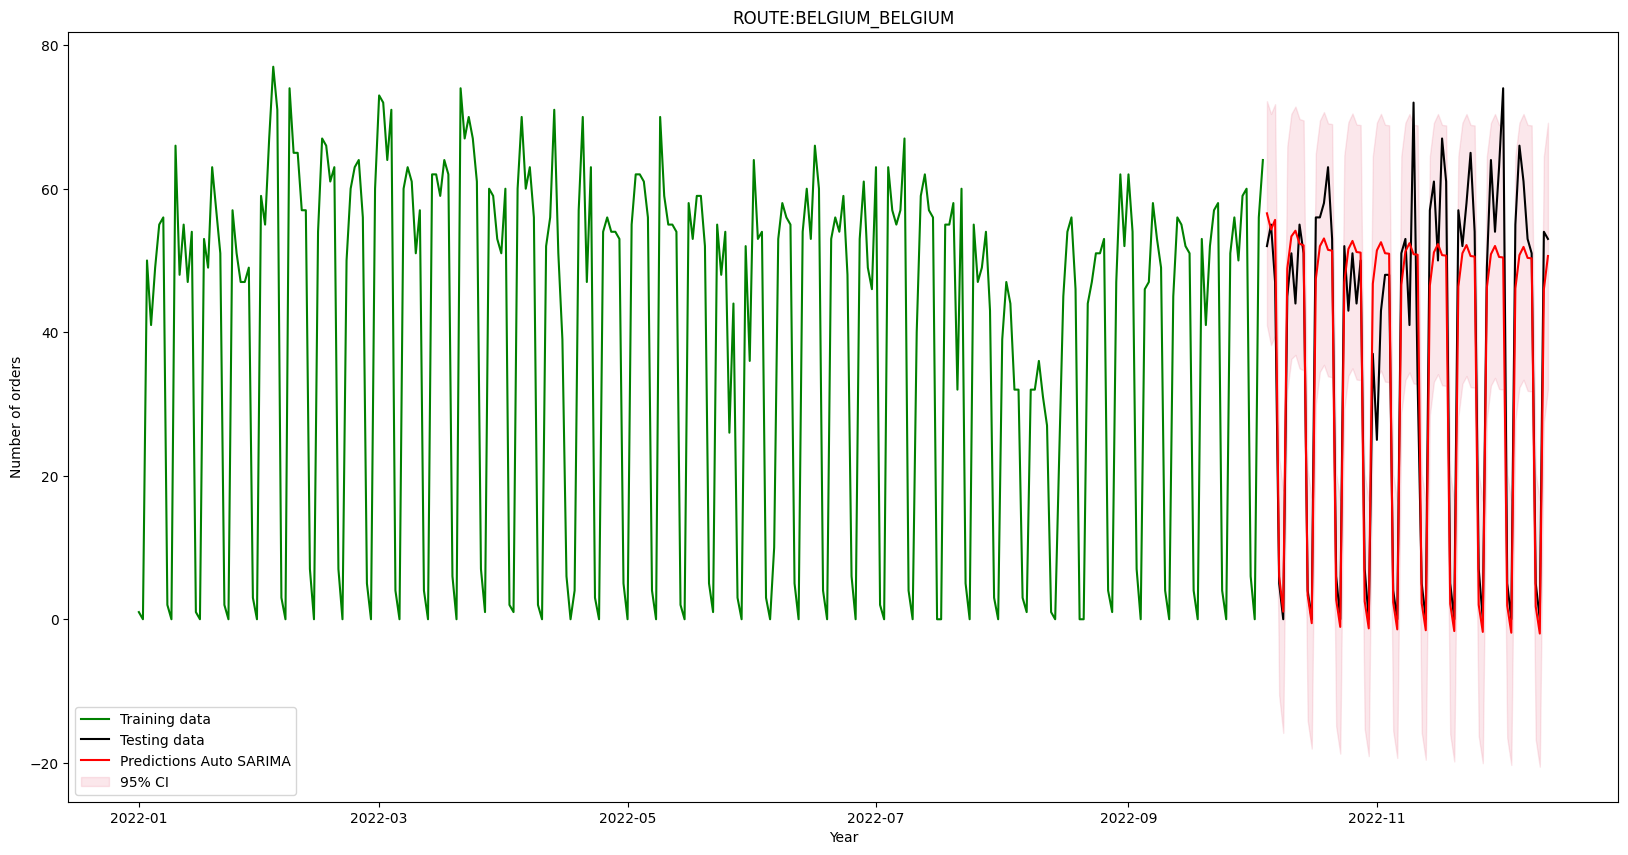

In [27]:
model_SARIMA = result_SARIMA_auto.get_prediction(start=test.index[0], end=test.index[-1])
df_auto_sarima = model_SARIMA.summary_frame()
plt.figure(figsize=(20, 10))
plt.title('ROUTE:BELGIUM_BELGIUM') # attenzione MODIFicare quando farà loop sulle tratte!!! 
plt.plot(train, color='green',label='Training data')
plt.plot(test, color='black', label='Testing data')
plt.plot(df_auto_sarima['mean'], color='red', label='Predictions Auto SARIMA')
plt.fill_between(df_auto_sarima.index, df_auto_sarima['mean_ci_lower'], df_auto_sarima['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
plt.xlabel('Year')
plt.ylabel('Number of orders')

plt.legend()

with m = 30
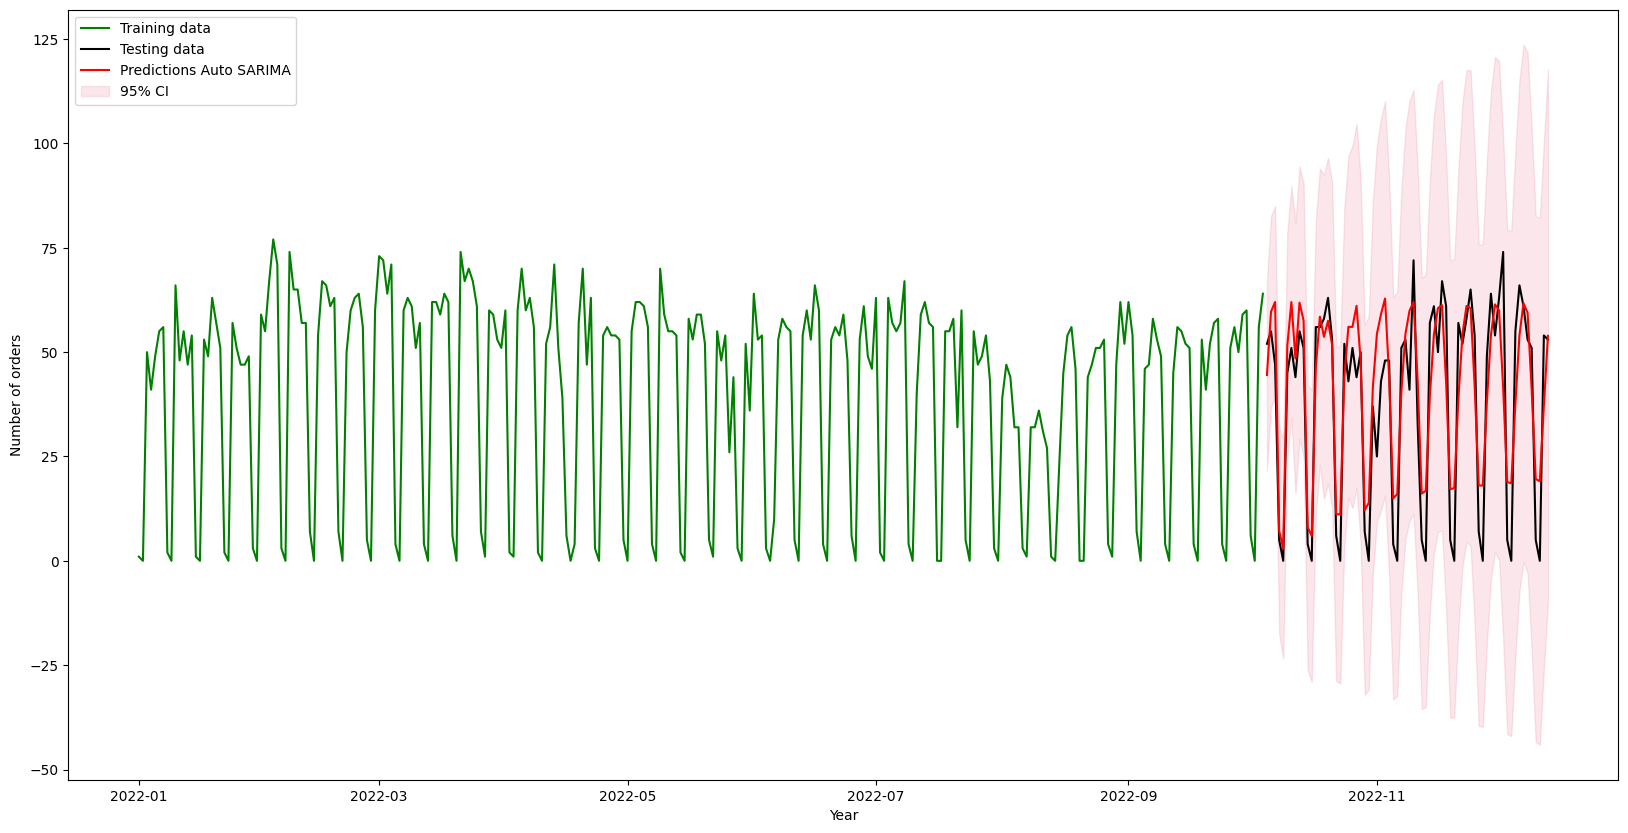

with m = 7
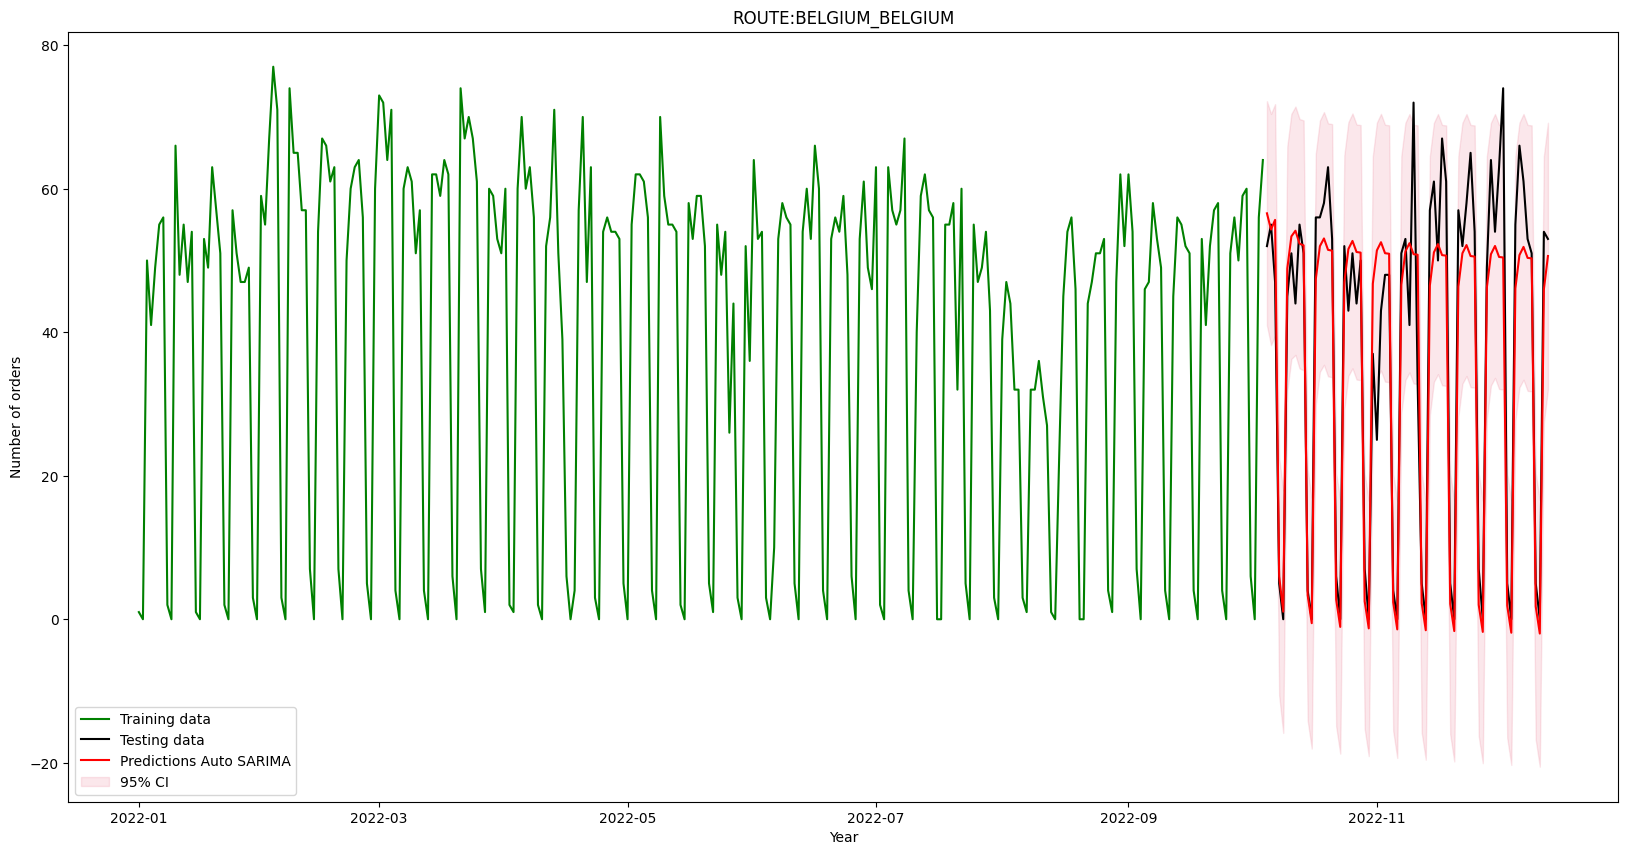